# **Risk parity project - Main notebook**

by [Viet Hung Ha](https://www.linkedin.com/in/viethungha0610/)


This is the main descriptive notebook. I plan to keep as little technical and mathmatical details as possible. I will mainly focus on the implementation and application of this programme.

## The problem:

To manage risk, one usually has to look to portfolio diversification, be it stocks, asset classes, or agricultural crops. A naive way to diversify is to attribute equal weighting to each asset in the portfolio e.g. if n_assets=2, then the allocation is 50/50. However, depending on the individual risk profile of each asset and their correlation, the portfolio might not be diversified at all.


Take a typical 60/40 Equity/Bond portfolio, one might think 60% of risk is in Equity and 40% in Bond. However, about 90% of the portfolio risk will be driven by Equity as it is generally a more volatile asset class.


With this intuition, how does one split their portfolio so that each of the individual investment carry the same amount of risk (not dollar investment)? 

The answer is a Risk Parity Portfolio, in which each asset's **marginal** risk contribution is measured and weighted accordingly so that all assets contribute equal amount of risk to the portfolio.

This project is based on the body of research on Risk Parity Portfolio. My project would not have existed without the research on this area.

**Core References for the mathematical foundation:**

1. [Braga, 2016](https://www.springer.com/gp/book/9783319243801)
2. [Palomar, 2019](https://palomar.home.ece.ust.hk/MAFS6010R_lectures/slides_risk_parity_portfolio.html#1)
3. [Maillard, Roncalli and Teïletche, 2010](https://jpm.pm-research.com/content/36/4/60.abstract)

The project will mainly have 3 components:
1. **Data importing component**: connecting with an API to get structured data on asset prices

2. **Preprocessing component**: to receive (or even gather) readily available data and generate input into the Risk Parity optimisation model

3. **Optimization component**: responsible for the optimisation and generate asset allocation as output

4. **Output component**: generate meaningful statistics and visualisation to inform investment decisions, along with an Excel file with allocation

**Future**
5. The project will be refined over time and adding **customizable risk budgets** will be the next target. This will significantly increase the complexity of the project. Instead of having Risk Parity, one may want a bit more risk contribution from a specific asset than another one.

## Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import sympy
from scipy.optimize import minimize
import scipy.linalg as la

# 1. Class design 
## 1a. Convex formulation

Problem:\
\
$minimize_{\mathbf{x}\geq0} \; \; \frac{1}{2}\mathbf{x}^T\Sigma\mathbf{x} - \mathbf{b}\log{(\mathbf{x})} $ \
\
Whereby:\
\
$\mathbf{x} \; = \; \frac{\mathbf{w}}{\sqrt{\mathbf{w}^T\Sigma\mathbf{w}}}$

**Important attributes:**
1. **Marginal risk contribution (MRC)** of the $i$th asset to the total risk of $\sigma(\mathbf{w})$:\
\
$ MRC_i \; = \; \frac{\partial\sigma}{\partial w_i} \; = \; \frac{(\Sigma\mathbf{w})_i}{\sqrt{\mathbf{w}^T\Sigma\mathbf{w}}}$\
\
This measures the sensitivity of the portfolio volatility to the $i$th asset weight.


2. **Risk contribution (RC)** from the $i$th asset to the total risk $\sigma(\mathbf{w})$:\
\
$ RC_i \; = \; w_i\frac{\partial\sigma}{\partial w_i} = \frac{w_i(\Sigma\mathbf{w})_i}{\sqrt{\mathbf{w}^T\Sigma\mathbf{w}}} $


3. **Relative risk contribution (RRC)** is the ratio of an asset's RC to the total portfolio risk $\sigma(\mathbf{w})$:\
\
$RRC_i \; = \; \frac{RC_i}{\sigma(\mathbf{w})} \; = \; \frac{w_i(\Sigma\mathbf{w})_i}{\mathbf{w}^T\Sigma\mathbf{w}}$


Note that:


$\Sigma$ is the Variance-Covariance matrix of the portfolio\
and\
$\mathbf{w}$ is the vector of portfolio assets' weights

In [2]:
# Parent class
class RiskParity():
    """
    This is the main Risk Parity class, where main operations such as calculating the risk function
    """
    from scipy.optimize import minimize
    import numpy as np
    def __init__(self, 
                 cov_mat,
                 assets=None,
                 w_guess=None):
        """Inserting data into class"""
        """Following guidance in Braga (2016), the class will by default favour optimisation via SQP"""
        """
        Args:
            cov_mat (array): the return covariance matrix 
            assets (list): list of asset names or ticker 
            w_guess (list or array): initial guess for Risk Parity asset allocation, if not specified the default will be equal weights 

        Raises:
            ValueError: if the number of assets is not equal to the number of rows/columns of the covariance matrix.
        """
        self.cov_mat = cov_mat
        self.assets = assets
        if w_guess is None:
            w_guess=np.full((self.cov_mat.shape[0]), 1/self.cov_mat.shape[0])
            self.w_guess = w_guess
        self.w_guess = w_guess
        # Error handling: Making sure len(assets) == len(cov_mat.shape[0])
        if len(self.assets) != self.cov_mat.shape[0]:
            raise ValueError('Number of assets must be equal to number of rows/columns of the covariance matrix')

    def risk_func(self, w=None):
        """Main risk function to minimise - convex risk function. In this class, this is a helper function.
        Args:
            w (list or array): initial guess for Risk Parity asset allocation, if not specified the default will be equal weights (list or array)

        Returns:
            risk_func (float): the calculated risk function
        """
        # Start off with vector x
        if w is None:
            w = self.w_guess
        b_T = 1/len(w)
        w_T = w.T
        x = w / (np.sqrt(w_T.dot(self.cov_mat).dot(w)))
        # Then the main function
        x_T = x.T
        risk_func = 0.5*x_T.dot(self.cov_mat).dot(x) - b_T*(np.sum(np.log(x)))
        self.risk_func_ = risk_func
        return risk_func
    
    def optimize(self, assets=None, method='SLSQP'):
        """This method minimize the risk function (risk_func) and displays a Risk Parity asset allocation.

        Args:
            assets (list): list of name of assets, if not specified then using the same list of assets when the class instance is initiated. 
            method (str): method for optimization, default is Sequential Least Squares Programming (SLSQP). 
            For full list of optimization method,
                refer to [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html]
        
        Attributes:
            allocation_ (list): the Risk Parity asset allocation 
            allocation_df_ (Pandas DataFrame): a Pandas DataFrame with 2 columns: 1. asset names and 2. their Risk Parity allocation 
            minimised_val_ (float): the minimised value of the convex risk function 
        """
        self.method = method
        if assets is None:
            assets=self.assets
        opti_result = minimize(self.risk_func, self.w_guess, 
                               method=self.method)
        allocation = opti_result.x / sum(opti_result.x)
        print('Minimised convex risk function value: {:.4f}'.format(opti_result.fun))
        allocation_df = pd.DataFrame({'Assets':assets, 
                                      'Allocation':np.round(allocation, 4)})
        display(allocation_df)
        self.allocation_ = allocation
        self.allocation_df_ = allocation_df
        self.minimised_val_ = opti_result.fun
    
    def cal_risk_stats(self, assets=None):
        """This method calculates marginal risk contribution (MRC), risk contribution (RC)
        and relative risk contribution (RRC) of the ith asset.
        
        Args:
            assets (list or array): list of name of assets, if not specified then using the same list of assets when the class instance is initiated. 

        Attributes:
            MRC_ (array): marginal risk contribution of the ith asset 
            RC_ (array): risk contribution of the ith asset 
            RRC_ (array): relative risk contribution of the ith asset 
        """
        if assets is None:
            assets=self.assets
        w_rpp = self.allocation_
        w_rpp_T = w_rpp.T
        portfolio_vol = np.sqrt(w_rpp_T.dot(self.cov_mat).dot(w_rpp))
        
        # Marginal risk contribution (MRC)
        MRC_num = self.cov_mat.dot(w_rpp)
        MRC_denom = portfolio_vol
        MRC = []
        for val, i in zip(MRC_num, range(len(assets))):
            MRC.append(MRC_num[i] / MRC_denom)
        self.MRC_ = MRC
        
        # Risk contribution (RC)
        RC_component = self.cov_mat.dot(w_rpp)
        RC_denom = portfolio_vol
        RC = []
        for i in range(len(assets)):
            RC.append((w_rpp[i]*RC_component[i]) / RC_denom)
        self.RC_ = RC
        
        # Relative risk contribution (RRC)
        RRC_component = self.cov_mat.dot(w_rpp)
        RRC_denom = portfolio_vol**2
        RRC = []
        for i in range(len(assets)):
            RRC.append((w_rpp[i]*RRC_component[i]) / RRC_denom)
        self.RRC_ = RRC
    
    def visualise_risk_stats(self):
        """
        This method visualises the risk statistics from the cal_risk_stats method above.
        
        Attributes:
            MRC_fig_ (matplotlib fig): matplotlib figure of the marginal risk contribution (MRC) of all assets in the portfolios
            RC_fig_ (matplotlib fig): matplotlib figure of the risk contribution (RC) of all assets in the portfolios
            RRC_fig_ (matplotlib fig): matplotlib figure of the relative risk contribution (RRC) of all assets in the portfolios
        """
        import seaborn as sns
        import matplotlib.pyplot as plt
        # MRC_i visualisation
        MRC_fig = sns.barplot(y=self.MRC_, x=self.assets)
        MRC_fig.set_title('Marginal risk contribution (MRC) to total portfolio risk')
        self.MRC_fig_ = MRC_fig
        plt.show()
        # RC_i visualisation
        RC_fig = sns.barplot(y=self.RC_, x=self.assets)
        RC_fig.set_title('Risk contribution (RC) to total portfolio risk')
        self.RC_fig_ = RC_fig
        plt.show()
        # RRC_i visualisation
        RRC_fig = sns.barplot(y=self.RRC_, x=self.assets)
        RRC_fig.set_title('Relative risk contribution (RRC) to total portfolio risk')
        self.RRC_fig_ = RRC_fig
        plt.show()
        
    def out_excel(self, directory=None):
        """This method outputs an excel file with the asset allocation.
        
        Args:
            directory (str): the directory in which to output the Excel file.
                If the directory is not specified, the method will output the file in the current working directory"""
        import os
        self.directory = directory
        if directory is None:
            self.directory = os.getcwd()
        allocation_to_excel = self.allocation_df_.to_excel(f'{self.directory}/RP_allocation.xlsx', index=False)
        return allocation_to_excel

## 1b. Non-convex formulation

[Maillard et al. (2010)](https://jpm.pm-research.com/content/36/4/60) formulation:\
\
Problem:\
\
$minimize_\mathbf{w} \; \sum_{i,j=1}^{N}(w_i(\mathbf{\Sigma}\mathbf{w})_i \; - \; w_j(\mathbf{\Sigma}\mathbf{w})_j)^2$\
\
Subject to:\
\
$\mathbf{1}^T\mathbf{w} \; = \; 1 \;, \; \mathbf{w}\geq0.$\
\
Generally, the Convex formulation will perform better i.e. achieving equal $RRC_i$ across assets.

In [3]:
# Child class of RiskParity
class NonConvexRP(RiskParity):
    """
    This child class inherits all of methods from the parent RiskParity class, except risk_func() and optimize()
        to account for the non-convex formulation of the optimization problem.
    """
    def risk_func(self, w=None):
        """This is the modified optimise function for non-convex problem formulation
        DISCLAIMER: as this does not take into account the long-only and capital budget constraints, this may not work 100%.

        Args:
            w (list or array): initial guess for Risk Parity asset allocation, if not specified the default will be equal weights

        Returns:
            risk_func (float): the calculated risk function
        """
        if w is None:
            w = self.w_guess
        n = len(w)
        risk_budget = 1 / n
        risks = w * (self.cov_mat.dot(w))
        norm_risks = risks / risk_budget
        g = np.tile(norm_risks, n) - np.repeat(norm_risks, n)
        """Example: assuming n = 2 and norm_risk is [a, b, c]
                                np.tile -> [a, b, c, a, b, c]
                                np.repeat -> [a, a, b, b, c, c]
                                np.tile - np.repeat
                                i = 1, 2, 3 ;  j = 1
                                Taking all the 1, 2, 3 minus the 1
                                i = 1, 2, 3 ;  j = 2
                                and so on ...
                                i = 1, 2, 3 ;  j = 3
                                By taking np.tile - np.repeat, one gets all the permutations of N assets taken 2 at a time (pairs of i and j) 
                                """
        return np.sum(g**2) # This is the main function to minimise, a SUM OF SQUARES, (NOT SQUARE OF SUM) 
    
    def optimize(self, assets=None, method='BFGS'):
        """This method minimize the risk function (risk_func) and displays a Risk Parity asset allocation.

        Args:
            assets (list): list of name of assets, if not specified then using the same list of assets when the class instance is initiated. 
            method (str): method for optimization, default is the Broyden–Fletcher–Goldfarb–Shanno (BFGS). 
            For full list of optimization method,
                refer to [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html]
        
        Attributes:
            allocation_ (list): the Risk Parity asset allocation 
            allocation_df_ (Pandas DataFrame): a Pandas DataFrame with 2 columns: 1. asset names and 2. their Risk Parity allocation 
            minimised_val_ (float): the minimised value of the convex risk function"""
        self.method = method
        if assets is None:
            assets=self.assets
        opti_result = minimize(self.risk_func, self.w_guess, 
                               method=self.method)
        allocation = opti_result.x / sum(opti_result.x)
        print('Minimised non-convex risk function value: {:.4f}'.format(opti_result.fun))
        allocation_df = pd.DataFrame({'Assets':assets, 
                                      'Allocation':np.round(allocation, 4)})
        display(allocation_df)
        # Important attributes below
        self.allocation_ = allocation
        self.allocation_df_ = allocation_df
        self.minimised_val_ = opti_result.fun

# 2. Data preparation class

This class turns an imported csv of asset prices to a covariance matrix (Matrix $\mathbf{A}$), which can be used as input for *RiskParity* or *NonConvexRP* classes.

In [4]:
# The preprocessing part of the programme. Receiving csv -> Returning cov_mat
class PrepDataRP():
    """This class aims to turn an imported csv file into a return covariance matrix (Matrix A), which can be used as an input for the RiskParity or NonConvexRP classes above"""
    import pandas as pd
    import numpy as np
    def __init__(self, df=None):
        """
        Initiator

        Args:
            df (Pandas DataFrame): the DataFrame to preprocess 
                It should have the following format:
                    1 column with the dates
                    n columns with the asset prices, with correct date-asset price combination
        """
        self.df = df
        
    def transform(self, df=None):
        """
        This method transforms the correctly formatted Pandas DataFrame into a covariance matrix to be as an input for the RiskParity or NonConvexRP classes above.
        
        Attributes:
            assets_ (list): the names of the assets i.e. the column names of the formatted Pandas DataFrame 

        Returns:
            cov_mat (array): the return covariance matrix, which can be used as an input for the RiskParity or NonConvexRP classes above 
        """
        if df is None:
            df = self.df
        # Drop NaN values to make sure asset time series have the same # of observatives
        df = df.dropna()
        # Filter by numeric data types
        numeric_cols = list(df.loc[:, df.dtypes==np.float64].columns) + list(df.loc[:, df.dtypes==np.int64].columns)
        price_data = df[numeric_cols]
        assets = price_data.columns.tolist()
        returns_df = (price_data.iloc[1:,:].values / price_data.iloc[:-1,:] - 1)
        excess_returns_df = returns_df - returns_df.mean()
        excess_returns = np.array(excess_returns_df)
        excess_returns_T = excess_returns.T
        cov_mat = excess_returns_T.dot(excess_returns) / (excess_returns.shape[0] - 1)
        # Getting the name of the assets through this attribute
        self.assets_ = assets
        return cov_mat

# 3. Online data importing class

Using RapidAPI

In [5]:
class api_data():
    """
    This class imports data from RapidAPI's Yahoo Finance API, then outputs a time series DataFrame with date and prices of selected assets.
    """
    def __init__(self, api_key, assets, start, finish, freq):
        """
        Initiator

        Args:
            api_key (str): one's own API key. For instructions, refer to the Instruction notebook.
            assets (list): List of ticker, must be valid and available on Yahoo finance
            start (str): start date of time series, in the format of YYYY-MM-DD
            finish (str): finish date of time series, in the format of YYYY-MM-DD
            freq (str): the frequency of data:
                  '1d': daily
                  '1wk': weekly
                  '1mo': monthly 
        """
        self.api_key = api_key
        self.assets = assets # List of assets, to be looped later
        self.start = start
        self.finish = finish
        self.freq = freq
    
    def time_to_unix(self, date, pattern='%Y.%m.%d'):
        """
        Helper method: converting real time to unix timestamps

        Args:
            date (str): date, in the format of YYYY-MM-DD by default
            pattern (str): date pattern to process, by default it is '%Y.%m.%d'

        Returns:
            unix (int): equivalent timestamp item of date arg. 
        """
        import time
        unix = int(time.mktime(time.strptime(date, pattern)))
        return unix

    def get_api_data(self, api_key, asset, start, finish, freq):
        """
        Helper method: getting raw data from RapidAPI's Yahoo Finance API
        
        Returns:
            response_json (json): a json file containing historical data 
        """
        import requests
        import json
        start = self.time_to_unix(self.start, pattern='%Y.%m.%d')
        finish = self.time_to_unix(self.finish, pattern='%Y.%m.%d')
        url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data"
        querystring = {"frequency":self.freq, "filter":"history", "period1":start,
                       "period2":finish,"symbol":asset}
        headers = {
            'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
            'x-rapidapi-key': self.api_key
            }
        response = requests.request("GET", url, headers=headers, params=querystring)
        response_json = json.loads(response.text)
        return response_json

    def make_time_series(self, response_json, asset=None):
        """
        Helper method: turning the response_json file into a time series DataFrame (with date and price columns)

        Args:
            response_json (json): a json file containing historical data
            asset (str, optional): name of asset / ticker

        Returns:
            times_series_df (Pandas DataFrame): time series DataFrame
        """
        from datetime import datetime
        import pandas as pd
        date_list_unix = []
        adj_close_list = []
        for index in range(len(response_json['prices'])):
            if len(response_json['prices'][index]) == 7:
                adj_close = response_json['prices'][index]['adjclose']
                adj_close_list.append(adj_close)
                date = response_json['prices'][index]['date']
                date_list_unix.append(date)
        date_list = [datetime.fromtimestamp(unix_date) for unix_date in date_list_unix] # Convert unix to human date
        date_list_ymd = [item.date() for item in date_list] # Getting date (years, months and days) only
        time_series_df = pd.DataFrame({'Date':date_list_ymd, f'{asset}':adj_close_list})
        return time_series_df

    def prep_data(self, api_key=None, assets=None, 
                  start=None, finish=None, freq=None): 
        """
        Main function, using the helper methods. This method gets the data from the API, processes it and returns a DataFrame:
            1. a date column
            2. N price columns
            3. n rows each containing an observation 
            --> Shape: (n ,1+N)

        Returns:
            merged_df (Pandas DataFrame): the combined time series DataFrame
        """
        if api_key is None:
            api_key = self.api_key
        if assets is None:
            assets = self.assets
        if start is None:
            start = self.start
        if finish is None:
            finish = self.finish
        if freq is None:
            freq = self.freq
        time_series_dict = {}
        time_series_list = []
        for asset in self.assets: 
            # Go through the motions
            response_json = self.get_api_data(api_key=self.api_key, asset=asset, freq=self.freq, start=self.start, finish=self.finish)
            time_series_df = self.make_time_series(response_json=response_json, asset=asset)
            time_series_dict[f"{asset}_df"] = time_series_df # For example MSFT_df is a time series DataFrame with 2 cols: date and price
            # Now we got a time series dictionary with security name key and their time series DataFrame as value
            time_series_list.append(time_series_dict[f"{asset}_df"])
        merged_df = pd.concat(time_series_list, axis=1, join='outer')
        merged_df = merged_df.reindex(index=merged_df.index[::-1])
        merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
        return merged_df

# 4. Testing section

## 4.1 Testing with 4 assets

**4 stocks chosen:**\
\
AAPL, AMD, AMZN, CRM

In [6]:
preprocessor = PrepDataRP()
imported_csv = pd.read_csv('test_csv.csv')
test_cov_mat = preprocessor.transform(imported_csv)

The test_csv.csv file has infomation on 20 stocks, here we first test the programme with 4 stocks.

In [7]:
cov_mat_4 = test_cov_mat[:4,:4]
w_test = np.array([0.1, 0.4, 0.30, 0.20])
stocks = ['AAPL', 'AMD', 'AMZN', 'CRM']

As can be seen below, the PrepDataRP class has successfully turned the time series into a return covariance matrix, which will be used as an input for the RiskParity and NonConvexRP optimization classes.

In [8]:
cov_mat_4

array([[0.00533986, 0.00338664, 0.00199577, 0.00200882],
       [0.00338664, 0.02581699, 0.00506635, 0.00366825],
       [0.00199577, 0.00506635, 0.00648837, 0.00268539],
       [0.00200882, 0.00366825, 0.00268539, 0.00618483]])

### 4.1.1. Convex form - 4 assets

In [9]:
convex = RiskParity(cov_mat_4, stocks)
print(convex.optimize())
print(convex.cal_risk_stats())
print(convex.MRC_)
print(convex.RRC_)

Minimised convex risk function value: -0.8271


<ipython-input-2-f20dc0ad71d9>:49: RuntimeWarning: invalid value encountered in log
  risk_func = 0.5*x_T.dot(self.cov_mat).dot(x) - b_T*(np.sum(np.log(x)))


,Assets,Allocation
0,AAPL,0.3119
1,AMD,0.1423
2,AMZN,0.2648
3,CRM,0.2810


None
None
[0.050963177986407884, 0.11170853368667295, 0.060018301217916355, 0.05657811302512736]
[0.24999857818728488, 0.2500392479669842, 0.24995515063680895, 0.25000702320892176]


As can be seen below, AMD is has the highest Marginal risk contribution (MRC) in this portfolio of 4 assets

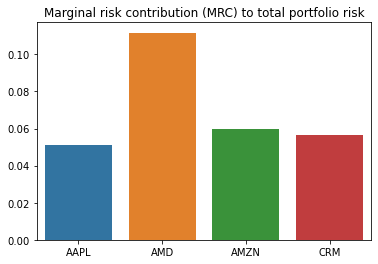

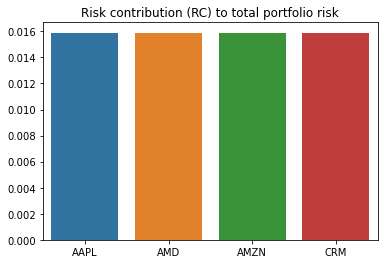

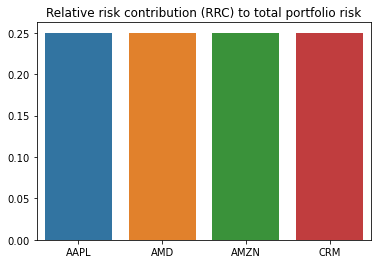

In [10]:
convex.visualise_risk_stats()

In [11]:
# Exporting to an Excel file - illustration
convex.out_excel()

### 4.1.2. Non-convex form - 4 assets

As can be seen in this example, the minimised non-convex risk function value is zero. This means that the difference in the risk contribution of any pair of assets $i, j$ in the portfolio is zero i.e. they contribute equal amount of risk.

In [12]:
# Testing code blocks
nonconvex_test = NonConvexRP(cov_mat_4, stocks)
print(nonconvex_test.risk_func())
print(nonconvex_test.optimize())
print(nonconvex_test.cal_risk_stats())
print(nonconvex_test.MRC_)
print(nonconvex_test.RC_)

0.00020899513635280474
Minimised non-convex risk function value: 0.0000


,Assets,Allocation
0,AAPL,0.3125
1,AMD,0.1420
2,AMZN,0.2633
3,CRM,0.2822


None
None
[0.05100706623552384, 0.11161503186781792, 0.059933078175166216, 0.05665658015074133]
[0.015939195240255128, 0.01585316713816126, 0.015779420711444846, 0.01598801758711347]


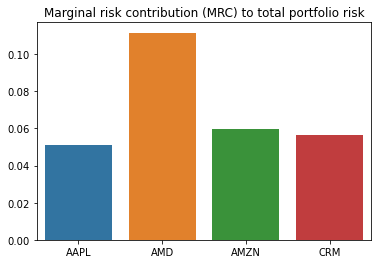

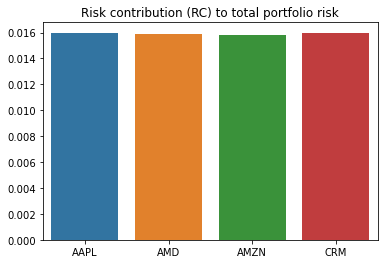

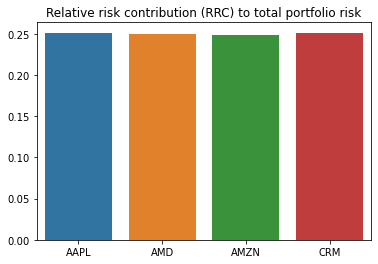

In [13]:
nonconvex_test.visualise_risk_stats()

## 4.2. Testing with 6 assets

Let's add GOOG and INTC into the mix and see how the function performs

In [14]:
# Let's test with more assets
stocks_6 = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC']
cov_mat_6 = test_cov_mat[:6,:6]

### 4.2.1. Convex form - 6 assets

Minimised convex risk function value: -0.6216


<ipython-input-2-f20dc0ad71d9>:49: RuntimeWarning: invalid value encountered in log
  risk_func = 0.5*x_T.dot(self.cov_mat).dot(x) - b_T*(np.sum(np.log(x)))


,Assets,Allocation
0,AAPL,0.1756
1,AMD,0.0839
2,AMZN,0.1483
3,CRM,0.1736
4,GOOG,0.1987
5,INTC,0.2200


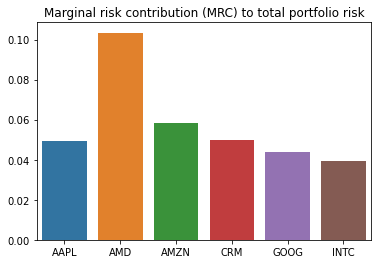

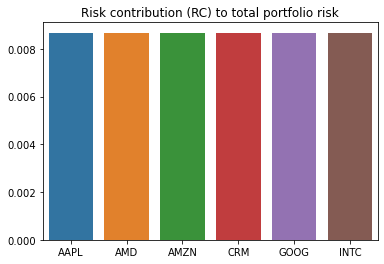

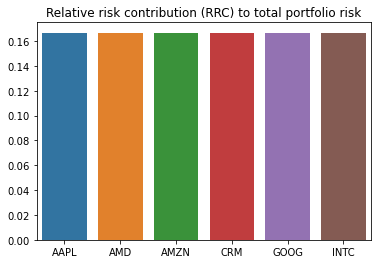

In [15]:
convex6 = RiskParity(cov_mat_6, stocks_6)
convex6.optimize()
convex6.cal_risk_stats()
convex6.visualise_risk_stats()

### 4.2.2. Non-convex form - 6 assets

Minimised non-convex risk function value: 0.0000


,Assets,Allocation
0,AAPL,0.1752
1,AMD,0.0838
2,AMZN,0.1489
3,CRM,0.1732
4,GOOG,0.1995
5,INTC,0.2193


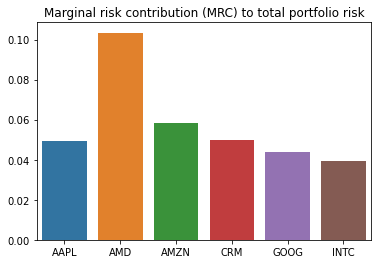

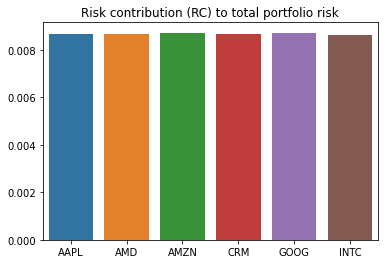

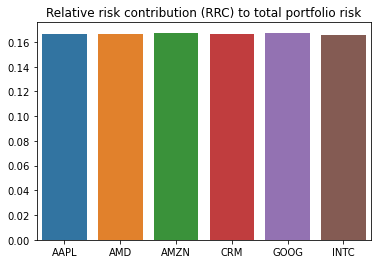

In [16]:
nonconvex6 = NonConvexRP(cov_mat_6, stocks_6)
nonconvex6.optimize()
nonconvex6.cal_risk_stats()
nonconvex6.visualise_risk_stats()

## 4.3. Testing with 8 assets:

Also, let's take a step further by using a csv file that has missing data, to make sure that the preprocessor PrepDataRP can handle this.

In [17]:
test_csv = pd.read_csv('test_csv_2.csv')
preprocessing = PrepDataRP()
cov_mat_8 = preprocessing.transform(test_csv)
assets = preprocessing.assets_
print(assets) # Different set of assets
display(test_csv)

['URTH', 'EEM', 'TIP', 'D5BE', 'GSG', 'SGOL ', 'GBF', 'INXG']


,Date,URTH,EEM,TIP,D5BE,GSG,SGOL,GBF,INXG
0,01/04/2003,NaN,8.578775,NaN,NaN,NaN,NaN,NaN,NaN
1,01/05/2003,NaN,9.361398,NaN,NaN,NaN,NaN,NaN,NaN
2,01/06/2003,NaN,9.754338,NaN,NaN,NaN,NaN,NaN,NaN
3,01/07/2003,NaN,10.307545,NaN,NaN,NaN,NaN,NaN,NaN
4,01/08/2003,NaN,11.130847,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
205,01/05/2020,89.789330,37.512344,121.500793,158.895004,9.82,16.680000,123.615997,20.549999
206,01/06/2020,91.214874,39.759308,123.000000,154.100006,10.37,17.139999,124.692322,20.665001
207,01/07/2020,96.650002,43.290001,125.860001,146.350006,10.75,18.990000,127.160942,20.805000
208,01/08/2020,102.709999,45.340000,126.010002,146.785004,11.21,18.559999,124.978065,19.698000


### 4.3.1. Convex form - 8 assets

Minimised convex risk function value: -1.6124


<ipython-input-2-f20dc0ad71d9>:49: RuntimeWarning: invalid value encountered in log
  risk_func = 0.5*x_T.dot(self.cov_mat).dot(x) - b_T*(np.sum(np.log(x)))


,Assets,Allocation
0,URTH,0.0776
1,EEM,0.0544
2,TIP,0.1783
3,D5BE,0.2026
4,GSG,0.0621
5,SGOL,0.0718
6,GBF,0.2440
7,INXG,0.1090


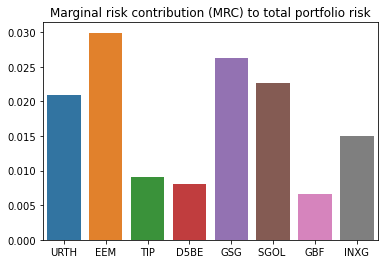

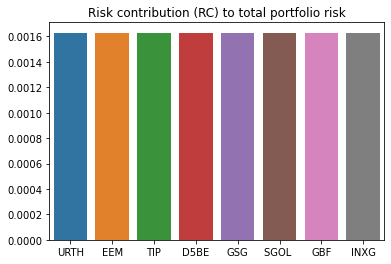

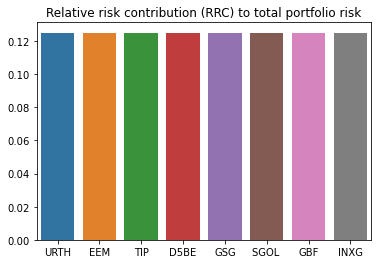

In [18]:
test_rpp = RiskParity(cov_mat_8, assets)
test_rpp.optimize()
test_rpp.cal_risk_stats()
test_rpp.visualise_risk_stats()

### 4.3.2. Non-convex form - 8 assets

Minimised non-convex risk function value: 0.0000


,Assets,Allocation
0,URTH,0.0777
1,EEM,0.0545
2,TIP,0.1783
3,D5BE,0.2028
4,GSG,0.0621
5,SGOL,0.0719
6,GBF,0.2439
7,INXG,0.1090


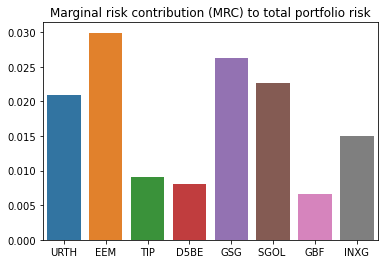

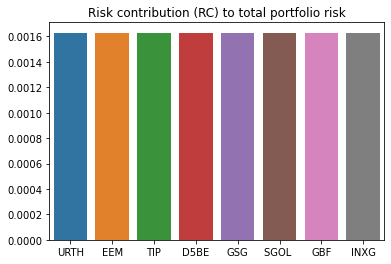

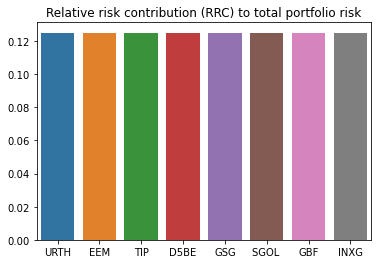

In [19]:
test_rpp_nc = NonConvexRP(cov_mat_8, assets)
# For this example, the Nelder-Mead method is more successful at the minimization function than BFGS
test_rpp_nc.optimize(method='Nelder-Mead')
test_rpp_nc.cal_risk_stats()
test_rpp_nc.visualise_risk_stats()

Everything seems to work fine! The preprocessor PrepDataRP can handle missing data.

## 4.4. Testing with 20 assets



In [20]:
# Even more assets - 20 stocks
stocks_20 = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NFLX', 
             'NVDA', 'V', 'ANAT', 'ATRI', 'CRVL', 'JOE', 'LORL', 'MORN', 
             'NHC', 'SEB', 'TR', 'UVV']
# This is the entire, non-sliced return covariance matrix
cov_mat_20 = test_cov_mat

### 4.4.1. Convex form - 20 assets

In [21]:
convex20 = RiskParity(test_cov_mat, stocks_20)
convex20.optimize()

Minimised convex risk function value: 0.2307


<ipython-input-2-f20dc0ad71d9>:49: RuntimeWarning: invalid value encountered in log
  risk_func = 0.5*x_T.dot(self.cov_mat).dot(x) - b_T*(np.sum(np.log(x)))


,Assets,Allocation
0,AAPL,0.0524
1,AMD,0.0192
2,AMZN,0.0375
3,CRM,0.0439
4,GOOG,0.0478
5,INTC,0.0563
6,MSFT,0.0483
7,NFLX,0.0276
8,NVDA,0.0275
9,V,0.0636


### 4.4.2. Non-convex form - 20 assets

In [22]:
nonconvex20 = NonConvexRP(test_cov_mat, stocks_20)
nonconvex20.optimize()

Minimised non-convex risk function value: 0.0000


,Assets,Allocation
0,AAPL,0.0524
1,AMD,0.0191
2,AMZN,0.0375
3,CRM,0.0440
4,GOOG,0.0477
5,INTC,0.0562
6,MSFT,0.0482
7,NFLX,0.0276
8,NVDA,0.0275
9,V,0.0638


# Further notes

For illustration of the API data importing module, refer to 'Illustrative case study' notebook